# Hypothesis-2:

1) make each batch in a sequence balanced<br>
2) make neural networks ensembles of seq.shape[0] <br>
3) train them<br>
4) do majority voting of results<br>

# findings:
1) did not work as sometimes the networks is biased towards 0, sometimes 1<br>
2) in 1 Case result was better but still 4 correct from 6 minority values<br>
3) sample generation seems only way forward<br>

In [687]:
import os
import torch 
from torch import nn
import torch.nn.functional as F
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,confusion_matrix, accuracy_score, classification_report
import re
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [688]:
from data_cleaning_new import clean, seq_gen, get_Xy, make_homogenous_sequence

In [689]:
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all(10)

[ Using Seed :  10  ]


In [690]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()


In [691]:
np.random.seed(10)
torch.manual_seed(10)

In [692]:
FILE_LOCATION=r'C:\Users\Asus\Videos\paper lstm transform\rethesis2014arnab\NonSMOTE\NonSMOTE\yeast-1_vs_7\yeast-1_vs_7-5-fold'
TRAIN_DATA='yeast-1_vs_7-5-1tra.dat'
TEST_DATA='yeast-1_vs_7-5-1tst.dat'
TRAIN_DATA_=os.path.join(FILE_LOCATION,TRAIN_DATA)
TEST_DATA_=os.path.join(FILE_LOCATION, TEST_DATA)

In [693]:
train_data=clean(TRAIN_DATA_)

In [694]:
train_data.head()

,0,1,2,3,4,5,6,7
0,0.58,0.44,0.57,0.13,0.5,0.54,0.22,0
1,0.48,0.45,0.59,0.20,0.5,0.58,0.34,0
2,0.43,0.39,0.54,0.21,0.5,0.53,0.27,0
3,0.42,0.37,0.59,0.20,0.5,0.52,0.29,0
4,0.58,0.47,0.54,0.11,0.5,0.51,0.26,0


In [668]:
IN=7
HU=35
model=nn.Sequential(nn.Linear(IN,HU),nn.Dropout(p=0.1),
                    nn.ReLU(),
                    nn.Linear(HU,HU),
                    nn.ReLU(),
                    nn.Linear(HU,HU),
                    nn.ReLU(),
                    nn.Linear(HU,IN),nn.Dropout(p=0.1),
                    nn.ReLU(),
                    nn.Linear(IN,1))

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.m=model
    def forward(self,x):
        output=self.m(x)
    
        return output

model=Model()
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.1, momentum=0.6, nesterov=True)
#optimizer=torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.6, nesterov=True)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [669]:
seq=seq_gen(train_data)
trainx,trainy=get_Xy(seq)

In [670]:
ensembles=[model for i in range(seq.shape[0])]

In [671]:
ensembles[0]

Model(
  (m): Sequential(
    (0): Linear(in_features=7, out_features=35, bias=True)
    (1): Dropout(p=0.1)
    (2): ReLU()
    (3): Linear(in_features=35, out_features=35, bias=True)
    (4): ReLU()
    (5): Linear(in_features=35, out_features=35, bias=True)
    (6): ReLU()
    (7): Linear(in_features=35, out_features=7, bias=True)
    (8): Dropout(p=0.1)
    (9): ReLU()
    (10): Linear(in_features=7, out_features=1, bias=True)
  )
)

In [672]:
def train_network(model, optimizer, scheduler,criterion, trainx, trainy,ensemble_no=0, epochs=201, print_=True):
    losses=[]
    for i in range(epochs):
        output=model(trainx)
        optimizer.zero_grad()
        loss=criterion(output.view(trainy.shape), trainy)
        
        losses.append(loss.item())
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        
    if print_==True:
        with torch.no_grad():
            print('ensemble_no: ', ensemble_no)
            print(classification_report(trainy, torch.sigmoid(output).round().view(trainy.shape)))
    
    return model, losses

In [673]:
def test(model, testx, testy):
    model.eval()
    with torch.no_grad():
        output=model(testx)
        print('test: ',classification_report(testy, torch.sigmoid(output).round().view(testy.shape)))
        

In [674]:
sc.fit_transform(trainx[0]).shape

(48, 7)

In [675]:
def train_ensembles(ensembles, trainx, trainy):
    trained_models=list()
    training_losses=list()
    
    trainy=torch.from_numpy(trainy).float()
    
    for i in range(trainx.shape[0]):
        batch=sc.fit_transform(trainx[i])
        batch=torch.from_numpy(batch).float()
        
        criterion=nn.BCEWithLogitsLoss()
        #optimizer=torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.6, nesterov=True)
        #optimizer=torch.optim.SGD(ensembles[i].parameters(),lr=0.01, momentum=0.6, nesterov=True)
        optimizer=torch.optim.Adam(ensembles[i].parameters(),lr=0.01)
        scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        
        trained_model,loss=train_network(ensembles[i],optimizer,scheduler,criterion,batch,trainy[i],ensemble_no=i,epochs=200,print_=True)
        
        trained_models.append(trained_model)
        training_losses.append(loss)
        
    return trained_models, training_losses

In [676]:
trained_models, losses=train_ensembles(ensembles, trainx, trainy)

ensemble_no:  0
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94        24
         1.0       0.92      0.96      0.94        24

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

ensemble_no:  1
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94        24
         1.0       0.92      0.96      0.94        24

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

ensemble_no:  2
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        24
         1.0       1.00      0.96      0.98        24

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98   

#testing

In [677]:
test_data=clean(TEST_DATA_)
test_data=test_data.values
testx=torch.from_numpy(test_data[:,:-1]).float()
testy=torch.from_numpy(test_data[:,-1]).float()

In [678]:
print(testx.shape)
print(testy.shape)

torch.Size([92, 7])
torch.Size([92])


In [679]:
torch.sigmoid(trained_models[13](testx)).round().shape

torch.Size([92, 1])

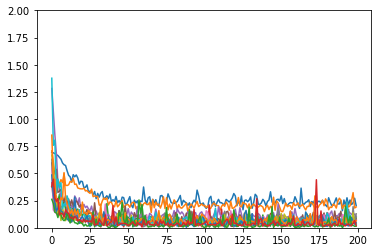

In [680]:
plt.ylim([0,2])
for i in losses:
    plt.plot(i)

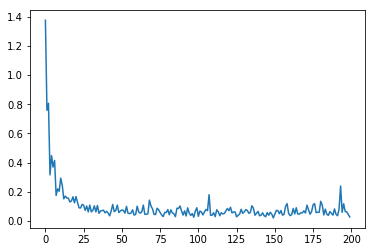

In [681]:
plt.plot(losses[9])

In [682]:
votes=torch.empty((testy.shape[0],len(ensembles)))

In [683]:
for i in range(len(trained_models)):
    votes[:,i]=torch.sigmoid(trained_models[i](testx)).round().squeeze()

In [684]:
votes[:,3]

tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1.], grad_fn=<SelectBackward>)

In [685]:
votes[:,6]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<SelectBackward>)

In [686]:
votes[77:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       gr